In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

In [14]:
L = 100

class Body():

    def __init__(self, x0, y0, l=L, sigma=0.02):
        self.x = x0
        self.y = y0
        self.box_size = l
        self.sigma=sigma
        self.history = [(x0, y0)]
        self.healthy = True

    def add_to_history(self, x, y):
        self.history.append((x, y))

    def get_infected(self):
        self.healthy=False

    @staticmethod
    def new_position(z, dz, box_size):
        
        zhat = abs(z + dz)
        
        if(zhat > box_size):
            zhat = 2*box_size - zhat 
        
        return zhat 

    def move(self):
        sigma = self.sigma *self.box_size
        dx = np.random.normal(loc=0.0, scale=sigma)
        dy = np.random.normal(loc=0.0, scale=sigma)

        self.x = Body.new_position(z=self.x, dz=dx, box_size=self.box_size)
        self.y = Body.new_position(z=self.y, dz=dy, box_size=self.box_size)

        self.add_to_history(self.x, self.y)

    def distance(self, other): 

        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def interact(self, other):
        pass

In [63]:
class Simulation():

    def __init__(self, n_bodies, num, l=L):
        self.box_size = l
        self.n_bodies = n_bodies
        self.num = num
        self.bodies  = [
            Body(np.random.uniform(low=0.0, high=self.box_size), np.random.uniform(low=0.0, high=self.box_size))
            for i in range(0, self.n_bodies)
        ]

    def run(self):
        for i in range(self.num):
            [b.move() for b in self.bodies]


sim = Simulation(n_bodies=100, num=100)
sim.run()


In [15]:
b_list = [
    Body(np.random.uniform(low=0.0, high=L), np.random.uniform(low=0.0, high=L))
    for i in range(0, 100)
]

for i in range(0, 200):
    [b.move() for b in b_list]

In [16]:
#df = pd.DataFrame(b1.history, columns=['x', 'y']).reset_index()

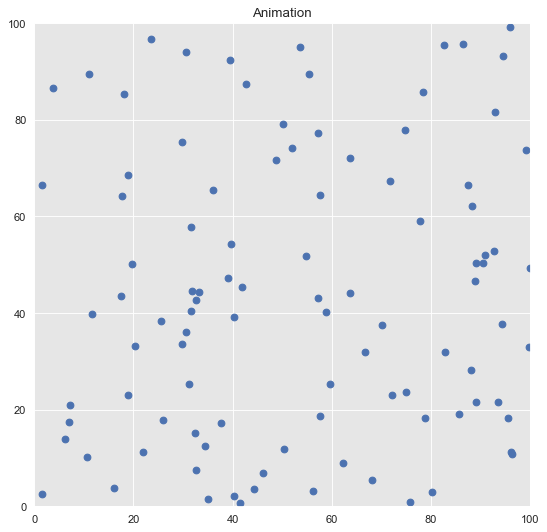

In [17]:
fig, ax = plt.subplots()
ax.set(title='Animation', xlim=(0, L), ylim=(0, L))

scat = ax.scatter([], [])

# animation function.  This is called sequentially
def animate(i):
    x = [b.history[i][0] for b in b_list]
    y = [b.history[i][1] for b in b_list]

    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    scat.set_offsets(np.concatenate((x, y), axis=1))
   
    return scat, 

anim = FuncAnimation(fig, animate, frames=100, interval=200, blit=True)
HTML(anim.to_jshtml())